In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install ETNA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 210 kB 15.5 MB/s 
     |████████████████████████████████| 3.3 MB 67.2 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 172 kB 96.1 MB/s 
     |████████████████████████████████| 79 kB 8.6 MB/s 
     |████████████████████████████████| 9.0 MB 44.5 MB/s 
     |████████████████████████████████| 57 kB 5.3 MB/s 
     |████████████████████████████████| 9.8 MB 48.5 MB/s 
     |████████████████████████████████| 918 kB 61.5 MB/s 
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
     |████████████████████████████████| 355 kB 72.3 MB/s 
     |████████████████████████████████| 132 kB 78.4 MB/s 
     |████████████████████████████████| 1.4 MB 57.7 MB/s 
     |████████████████████████████████| 79 kB 8.4 MB/s 
     |████████████████████████████████| 139 kB 67.5 MB/s 
     |████████████████████████████████|

# Импортируем библиотеки

In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from etna.datasets import TSDataset
from etna.transforms import HolidayTransform, LagTransform, TimeSeriesImputerTransform, DateFlagsTransform
from etna.transforms import MeanTransform, SegmentEncoderTransform, FourierTransform, StdTransform
from etna.pipeline import Pipeline
from etna.models.catboost import CatBoostModelPerSegment 
from etna.metrics import SMAPE
from etna.analysis import plot_backtest
from etna.analysis import plot_forecast

--------------------

# Загрузка и предобработка данных

In [306]:
data = pd.read_csv('/content/gdrive/MyDrive/data.csv', sep=';', parse_dates=True)

Посмотрим как распределены данные

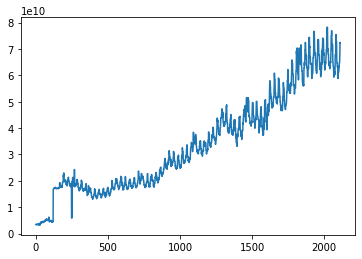

In [307]:
plt.plot(data['VALUE'])

Готовим датасет для преобразования к приемлемому формату для работы с ETNA

In [308]:
data['RD'] = data['REPORTDATE']
data['REPORTDATE'] = pd.to_datetime(data['REPORTDATE'])
data = data.set_index('REPORTDATE')

data = data.asfreq('D')
print(data.isna().sum()) # Смотрим, есть ли пропуски?
# Создадим датасет с заполненными пропусками
data_pad = data.pad()

VALUE    60
RD       60
dtype: int64


In [309]:
data_pad['segment'] = data_pad['VALUE'] # 'segment' - отдельный временной ряд для etna (временной ряд у нас 1)
data_pad['timestamp'] = data_pad['RD'] # 'timestamp' - временная метка для etna
data_pad = data_pad.drop(columns=['VALUE', 'RD'])


In [310]:
data_pad['target'] = data_pad['segment']
data_pad['segment'] = 'balance' # Назовем наш временной ряд
data_pad = data_pad.reset_index() # Обозначим индексы

In [311]:
data_pad = data_pad.drop(columns='REPORTDATE')

In [312]:
data_pad = data_pad.drop_duplicates()
data_pad # Посмотрим на получившийся датасет

,segment,timestamp,target
0,balance,30.12.2013,3.457626e+09
1,balance,31.12.2013,3.417092e+09
2,balance,01.01.2014,3.417092e+09
3,balance,01.02.2014,4.333582e+09
4,balance,01.03.2014,5.010720e+09
...,...,...,...
2166,balance,12.05.2019,7.355557e+10
2167,balance,12.06.2019,7.406256e+10
2168,balance,12.07.2019,7.822860e+10
2169,balance,12.08.2019,7.691720e+10


In [314]:
x_train, x_test = train_test_split(data_pad, test_size=0.1725, shuffle=False) # Разделим наш датасет на train и test части

In [315]:
x_test # Как мы видим, индексы принимают не те значения

,segment,timestamp,target
1746,balance,10.11.2018,6.579046e+10
1747,balance,10.12.2018,6.302985e+10
1748,balance,13.10.2018,6.217398e+10
1749,balance,14.10.2018,6.217398e+10
1750,balance,15.10.2018,5.704780e+10
...,...,...,...
2166,balance,12.05.2019,7.355557e+10
2167,balance,12.06.2019,7.406256e+10
2168,balance,12.07.2019,7.822860e+10
2169,balance,12.08.2019,7.691720e+10


In [316]:
x_test = x_test.reset_index(drop=True) # Если не сбросить индексы, то ETNA заполнит датасет и в train у нас будет 2170 строк

# Преобразуем данные к формату, приемлемому для ETNA

In [317]:
train_in_etna_format = TSDataset.to_dataset(x_train)
test_in_etna_format = TSDataset.to_dataset(x_test)

# Заполняем пропуски

In [318]:
nan_fill = TimeSeriesImputerTransform(in_column = 'target', strategy='running_mean', window=5)
ts_n = TSDataset(train_in_etna_format, freq="D")
ts_n.fit_transform([nan_fill])
ts_t = TSDataset(test_in_etna_format, freq="D")
ts_t.fit_transform([nan_fill])

/usr/local/lib/python3.7/dist-packages/etna/core/mixins.py:25: UserWarning: You haven't set all parameters inside class __init__ method: 'constant_value'
  warnings.warn(f"You haven't set all parameters inside class __init__ method: {e}")
/usr/local/lib/python3.7/dist-packages/etna/datasets/tsdataset.py:125: UserWarning: You probably set wrong freq. Discovered freq in you data is None, you set D
  f"You probably set wrong freq. Discovered freq in you data is {inferred_freq}, you set {self.freq}"
/usr/local/lib/python3.7/dist-packages/etna/core/mixins.py:25: UserWarning: You haven't set all parameters inside class __init__ method: 'constant_value'
  warnings.warn(f"You haven't set all parameters inside class __init__ method: {e}")


# Анализ данных с помощью ETNA

Попробуем найти сезонность с помощью графика автокорреляции

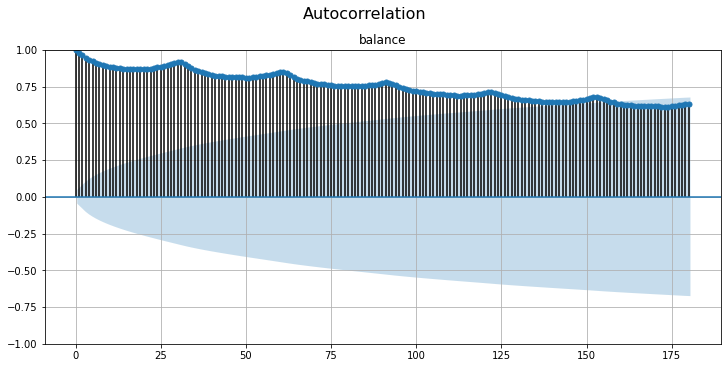

In [319]:
from etna.analysis import sample_acf_plot

sample_acf_plot(ts_n, lags=180)
# Видно, что присутсвует сезонность примерно в 30 дней

Посмотрим, какая из функций (линейная или кусочно-линейная) моделируют тренд наилучшим образом

/usr/local/lib/python3.7/dist-packages/etna/core/mixins.py:25: UserWarning: You haven't set all parameters inside class __init__ method: 'constant_value'
  warnings.warn(f"You haven't set all parameters inside class __init__ method: {e}")


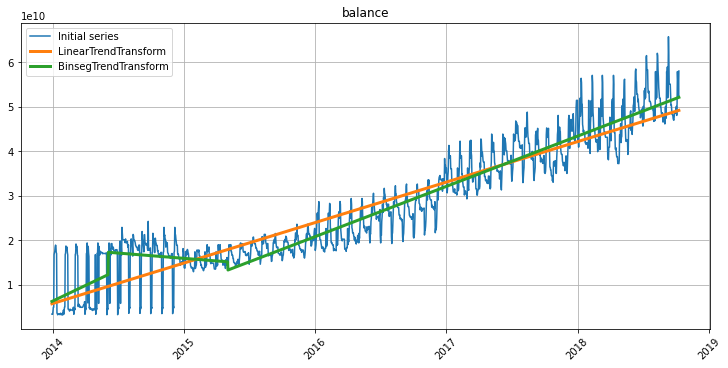

In [320]:
from etna.analysis import plot_trend
from etna.transforms import LinearTrendTransform, BinsegTrendTransform

ts_n.fit_transform([TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=3)])
plot_trend(
    ts=ts_n,
    trend_transform=[
        LinearTrendTransform(in_column="target"),
        BinsegTrendTransform(in_column="target", n_bkps=2, min_size=150),
    ],
)
# Как мы видим, кусочно-линейная функция справилась лучше, хоть различия невелики

# Прогнозирование ряда

Будем предсказывать HORIZON=365 дней, если нужно изменить количество дней, просто укажите другое. Однако, в тестовом датасете всего 425 дней, так что для проверки логичнее указывать не более 425

In [321]:
HORIZON = 365

В качестве модели мы использовали CatBoostModelPerSegment т.к. у нас всего 1 сегмент и сама модель показывает хорошее качество. В качестве фичей у нас: номер дня в месяце, номер дня недели, является ли день выходным/специальным днем, члены Фурье, является ли день праздничным днем в России, информация о временном ряде HORRZON, HORRZON+1, .... ,HORRZON+7 дней назад, среднее значение за 104 дня.
Метрика Smape  

In [322]:
lag_week = LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON+6)), out_column="regressor_lag")
mean_tr = MeanTransform(in_column="regressor_lag_{0}".format(HORIZON), out_column="regressor_mean", window=104, seasonality=30)
date_tr = DateFlagsTransform(out_column="d_flags",
                             day_number_in_week=True,
                             day_number_in_month=True,
                             is_weekend=True,
                             special_days_in_week=[4],
                            )
holiday_rus = HolidayTransform(iso_code="RUS", out_column="regressor_RUS_holidays")
holiday_lag_rus = LagTransform(in_column="regressor_RUS_holidays", lags=list(range(2,7)), 
                               out_column="regressor_RUS_holidays_lag")
fourier = FourierTransform(period=180, order=4, out_column="fourier")
bins_trend = BinsegTrendTransform(in_column="target", n_bkps=2, min_size=150)
model = CatBoostModelPerSegment(depth=5, learning_rate=0.35, l2_leaf_reg=0.8)
std = StdTransform(in_column='target', out_column='std', window=150, min_periods=150)

pipe = Pipeline(model=model, transforms=[lag_week, mean_tr, date_tr, 
                                         holiday_rus, fourier, bins_trend, holiday_lag_rus, std], 
                horizon=HORIZON)
smape = SMAPE()
metrics, forecast, info = pipe.backtest(ts=ts_n, metrics=[smape], n_folds=1, n_jobs=-1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated class CatBoostModelPerSegment. (CatBoostModelPerSegment is deprecated; will be deleted in etna==2.0. Use CatBoostPerSegmentModel instead.)
  
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished


In [323]:
metrics

,segment,SMAPE,fold_number
0,balance,9.492423,0


Получаем предсказания на HORRIZON дней вперед

In [324]:
pipe.fit(ts_n)
forecast = pipe.forecast()

Так как при применении срезов к датасету из ETNA он превращается в DataFrame из pandas, необходимо было написать функцию для вычисления метрики, которая будет работать с DataFrame (smape из ETNA с DataFrame не работает)

In [325]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

Так как тестовый датасет состоит из 425 дней, а мы можем предсказывать на меньшее количество дней, необходимо знать, какой день в предсказании был последним для корректного вычисления метрики

In [326]:
last_date = forecast['2018-10-11':].index[-1].strftime('%Y-%m-%d')
last_date

'2019-10-10'

In [327]:
smape(ts_t['2018-10-11':last_date]['balance']['target'], forecast['2018-10-11':]['balance']['target'])

5.450701407667853

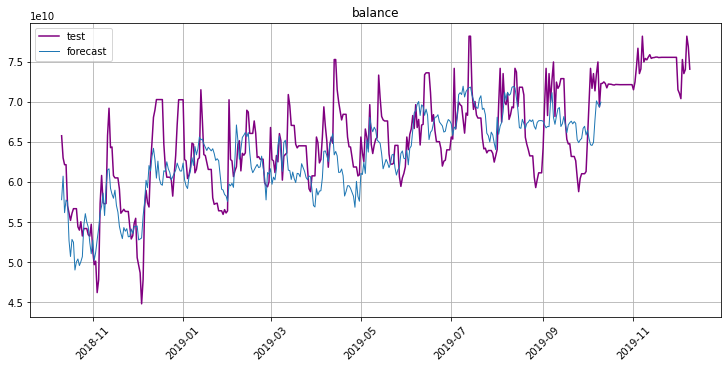

In [328]:
plot_forecast(forecast_ts=forecast, test_ts=ts_t)


# Стабильная часть средств на дату

In [330]:
# Функция показывает логарифм стабильной части средств на 12 месяцев вперед от  report_date
# Начало предсказаний начинается с 2018-10-11, поэтому необходимо ставить дату не раньше этой
# И не позднее '2019-10-10' потому что предсказания заканчиваются в этот день
def stable_part(forecast, report_date):
  if pd.to_datetime('2018-10-11') > pd.to_datetime(report_date):
    print('Укажите более позднюю дату(начиная с 2018-10-11)')
    return

  step = 30
  report_date_pd = pd.to_datetime(report_date)
  print('report_date bucket stable')
  
  for i in range(12):
    bucket = str(i + 1) + 'm'
    step_i_days = report_date_pd + pd.DateOffset(days=i*30)
    step_i_days = step_i_days.strftime('%Y-%m-%d')
    stable = forecast[report_date:step_i_days]['balance']['target'].min()
    print('%10s %3s %10.3f' % (report_date, bucket, np.log(stable)))

In [331]:
stable_part(forecast, '2018-10-11')

report_date bucket stable
2018-10-11  1m     24.780
2018-10-11  2m     24.615
2018-10-11  3m     24.615
2018-10-11  4m     24.615
2018-10-11  5m     24.615
2018-10-11  6m     24.615
2018-10-11  7m     24.615
2018-10-11  8m     24.615
2018-10-11  9m     24.615
2018-10-11 10m     24.615
2018-10-11 11m     24.615
2018-10-11 12m     24.615


# SMAPE = 7.56 (До работы над ошибками)


# SMAPE = 5.45 (После работы над ошибками)
Что было сделано в работе над ошибками: подбор гиперпараметров для модели, более точная настройка фичей и добавление новой (StdTransform), написана функция для отображения стабильной части средств на дату